In [1]:
!pip install ultralytics supervision -q
!pip install pillow
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of awscli to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of awscli to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.7/600.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.0/906.0 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [14]:
import numpy as np
import supervision as sv
import cv2
from ultralytics import YOLO

model = YOLO('/content/best (4).pt')

In [30]:
areas_of_interest= [
                        np.array([
                            [0, 77], [674, 77], [674, 0], [0, 0]
                                ]),
                        np.array([
                            [0, 328], [674, 328], [674, 398], [0, 398]
                                ])
                        ]

In [116]:
from PIL import Image
IMAGE_PATH = '/content/Arsenal_Aston Villa_14-Apr-24_loss_of_possession_26_21.png'
image = Image.open(IMAGE_PATH)
image_resolution_wh = image.size
print(image_resolution_wh)


(674, 398)


Total Home Detections: 8
Total Away Detections: 9


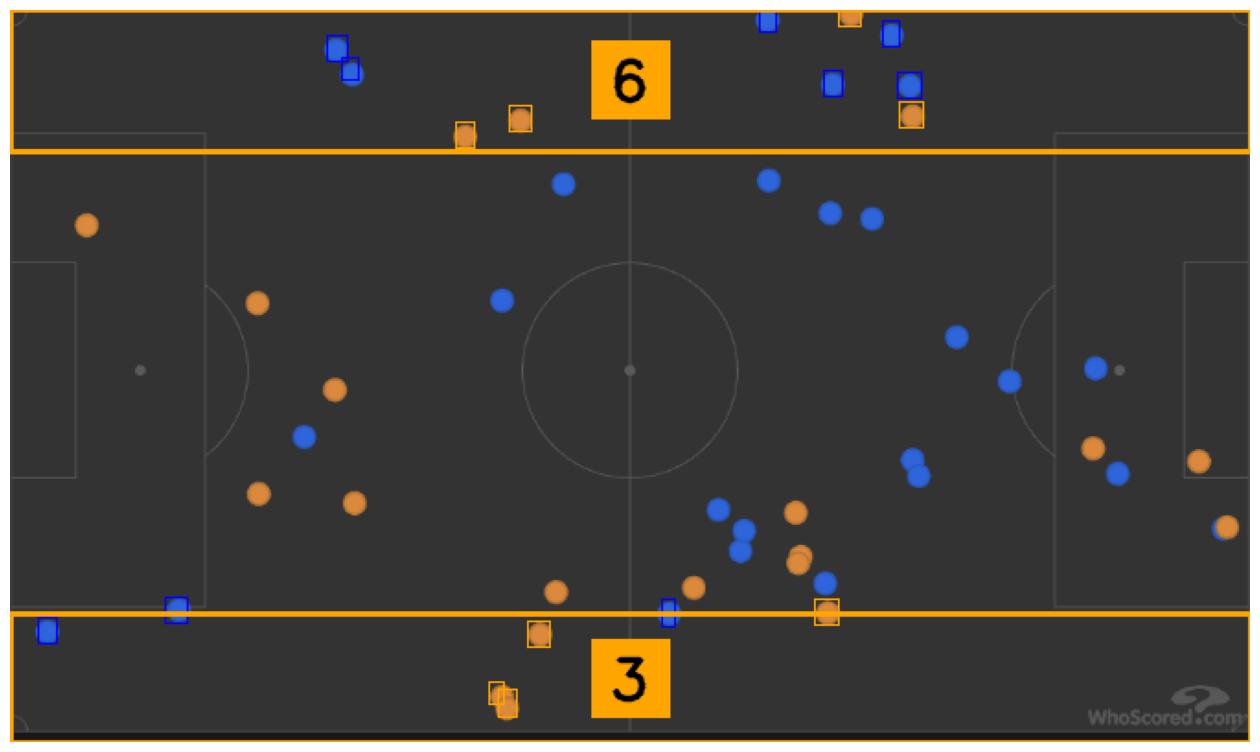

In [117]:
from PIL import Image
import numpy as np
import supervision as sv
from supervision.detection.overlap_filter import box_non_max_merge

# Minimal Color class to satisfy the library's requirement
class Color:
    def __init__(self, rgb):
        self.rgb = rgb

    def as_bgr(self):
        return self.rgb[::-1]  # Convert RGB to BGR

# Load and convert the image to a NumPy array
image = np.array(image)

# Ensure the image is in the correct data type for OpenCV
if image.dtype != np.uint8:
    image = image.astype(np.uint8)

# Create zones using the image resolution
zones = [
    sv.PolygonZone(
        polygon=polygon
    )
    for polygon in areas_of_interest
]

# Define colors for each class
orange = Color((255, 165, 0))  # Orange for "home" class
blue = Color((0, 0, 255))      # Blue for "away" class

# Create zone annotators (assuming you want the zones annotated with a certain color)
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=orange,  # You can change this color as needed
        thickness=2,
        text_thickness=2,
        text_scale=1
    )
    for zone in zones
]

# Initialize total counters for all zones
total_home = 0
total_away = 0

# Run the model on the image
results = model(image, imgsz=960, verbose=False, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

# Filter detections by class and confidence threshold
home_detections = detections[
    (detections.class_id == 1) & (detections.confidence >= 0.25)
]  # Assuming "home" is class 1

away_detections = detections[
    (detections.class_id == 0) & (detections.confidence >= 0.25)
]  # Assuming "away" is class 0

# Prepare data for Non-Max Merge (NMM)
home_predictions = np.hstack((home_detections.xyxy, home_detections.confidence[:, None], home_detections.class_id[:, None]))
away_predictions = np.hstack((away_detections.xyxy, away_detections.confidence[:, None], away_detections.class_id[:, None]))

# Apply Non-Max Merge (NMM)
home_merge_groups = box_non_max_merge(home_predictions, iou_threshold=0.05)
away_merge_groups = box_non_max_merge(away_predictions, iou_threshold=0.05)

# Manually merge detections based on merge groups
def merge_detections(detections, merge_groups):
    merged_boxes = []
    merged_confidences = []
    merged_class_ids = []

    for group in merge_groups:
        # Merge the boxes by averaging the coordinates (could use another strategy)
        group_boxes = detections.xyxy[group]
        merged_box = np.mean(group_boxes, axis=0)

        # Take the maximum confidence (could use another strategy)
        group_confidences = detections.confidence[group]
        merged_confidence = np.max(group_confidences)

        # Take the class ID from the first element (since they should all be the same in a group)
        merged_class_id = detections.class_id[group[0]]

        merged_boxes.append(merged_box)
        merged_confidences.append(merged_confidence)
        merged_class_ids.append(merged_class_id)

    return sv.Detections(
        xyxy=np.array(merged_boxes),
        confidence=np.array(merged_confidences),
        class_id=np.array(merged_class_ids)
    )

home_detections_nmm = merge_detections(home_detections, home_merge_groups)
away_detections_nmm = merge_detections(away_detections, away_merge_groups)

# Annotate home class detections with orange
home_box_annotator = sv.BoxAnnotator(color=orange, thickness=1)
for zone, zone_annotator in zip(zones, zone_annotators):
    mask = zone.trigger(detections=home_detections_nmm)
    total_home += np.sum(mask)
    detections_filtered = home_detections_nmm[mask]
    image = home_box_annotator.annotate(scene=image, detections=detections_filtered)
    image = zone_annotator.annotate(scene=image)

# Annotate away class detections with blue
away_box_annotator = sv.BoxAnnotator(color=blue, thickness=1)
for zone, zone_annotator in zip(zones, zone_annotators):
    mask = zone.trigger(detections=away_detections_nmm)
    total_away += np.sum(mask)
    detections_filtered = away_detections_nmm[mask]
    image = away_box_annotator.annotate(scene=image, detections=detections_filtered)
    image = zone_annotator.annotate(scene=image)

# Print the total counts for home and away across all zones
print(f"Total Home Detections: {total_home}")
print(f"Total Away Detections: {total_away}")

# Plot the annotated image
sv.plot_image(image, (16, 16))


(array([     128.28,      151.54,       139.7,      166.51], dtype=float32), None, 0.75021654, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([     128.72,      255.11,      140.22,      269.95], dtype=float32), None, 0.74245876, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([      240.9,      61.179,      253.34,      76.073], dtype=float32), None, 0.73152596, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([     180.63,      260.48,      191.18,      274.59], dtype=float32), None, 0.72959954, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([     271.01,      52.802,      282.47,      66.958], dtype=float32), None, 0.7182697, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([     659.52,      273.25,      667.86,      287.34], dtype=float32), None, 0.71373355, 1, None, {'class_name': 'home'})
<class 'tuple'>
(array([      582.3,       230.6,      594.78,      244.97], dtype=float32), None, 0.7131219, 1, None, {'class_name': 'home'})
<class 'tu

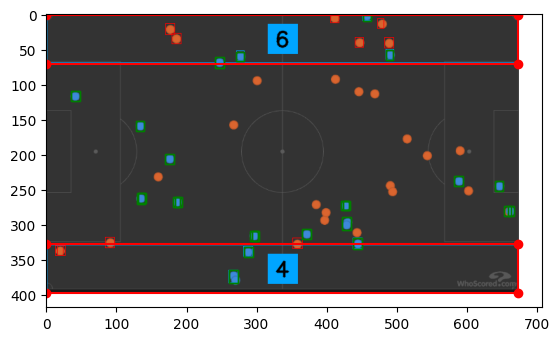

In [23]:
from supervision import Detections
import numpy as np
import matplotlib.pyplot as plt

# Initial logging to inspect the detection structure
for detection in home_detections:
    print(detection)
    print(type(detection))

# Extract bounding boxes, class IDs, and confidence scores to create a Detections object
bbox_list = [detection[0] for detection in home_detections]  # Bounding boxes
confidence_list = [detection[2] for detection in home_detections]  # Confidence scores
class_id_list = [detection[3] for detection in home_detections]  # Class IDs

bbox_array = np.array(bbox_list)
confidence_array = np.array(confidence_list)
class_id_array = np.array(class_id_list)

# Create a Detections object with the extracted data
detection_boxes = Detections(
    xyxy=bbox_array,
    class_id=class_id_array,
    confidence=confidence_array
)

# Debugging: Check intersections with polygon zones
for zone in zones:
    intersection = zone.trigger(detections=detection_boxes)
    print(f"Intersection with zone: {intersection}")

# Additional logging or debugging
for detection in home_detections:
    bbox = detection[0]  # Extract the bounding box
    print(f"Detection bbox: {bbox}")
    for zone in zones:
        print(f"Polygon: {zone.polygon}")
        # Use the Detections object to check intersection
        intersection = zone.trigger(detections=detection_boxes)
        print(f"Intersection: {intersection}")

# Visualization for further inspection
plt.imshow(image)
for zone in zones:
    plt.plot(*zone.polygon.T, linestyle='-', marker='o', color='r')
    for detection in detection_boxes.xyxy:
        plt.gca().add_patch(plt.Rectangle((detection[0], detection[1]),
                                          detection[2] - detection[0],
                                          detection[3] - detection[1],
                                          linewidth=1, edgecolor='g', facecolor='none'))
plt.show()
